In [6]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pandas as pd
import glob

# Function to read text files into dataframes with correct delimiter
def read_text_file(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True)  # Read the file with correct delimiter
    df.columns = df.columns.str.strip()  # Strip any extra whitespace
    return df

# Path to the directory in Google Drive
drive_dir = '/content/drive/My Drive/Colab Notebooks/PHQ9_annot_summstats/'

# List all CSV files in the directory
file_paths = glob.glob(drive_dir + '*.out')

# Read all files into dataframes
dfs = [read_text_file(file_path) for file_path in file_paths]



In [60]:
# Find all unique genes with P-value < 0.05 in any dataframe
all_genes = set()
for df in dfs:
    significant_genes = df[df['P'] < 0.05]['GENE']
    all_genes.update(significant_genes)

# Retain only these genes in all dataframes
final_dfs = [df[df['GENE'].isin(all_genes)] for df in dfs]

# Check all dataframes have same length
for i, df in enumerate(final_dfs):
    print(f"DataFrame {i} with {len(df)} rows")

DataFrame 0 with 18506 rows
DataFrame 1 with 18506 rows
DataFrame 2 with 18506 rows
DataFrame 3 with 18506 rows
DataFrame 4 with 18506 rows
DataFrame 5 with 18506 rows
DataFrame 6 with 18506 rows
DataFrame 7 with 18506 rows
DataFrame 8 with 18506 rows


In [66]:
# Retain only the "GENE" and "ZSTAT" columns and rename "ZSTAT" columns to distinguish them
renamed_dfs = []

for file_path, df in zip(file_paths, final_dfs):
    df = df[['GENE', 'ZSTAT']].copy()
    file_name = os.path.basename(file_path).replace('.out', '')  # Extract filename without extension
    df.rename(columns={'ZSTAT': file_name}, inplace=True)
    renamed_dfs.append(df)


# Merge all dataframes by the "GENE" column
merged_df = renamed_dfs[0]
for df in renamed_dfs[1:]:
    merged_df = merged_df.merge(df, on='GENE', how='outer')

# Check column names
merged_df.columns


Index(['GENE', 'Appetite_PHQ9.genes', 'Concentration_problems_PHQ9.genes',
       'Depressed_mood_PHQ9.genes', 'Inadequacy_PHQ9.genes',
       'Psychomotor_changes_PHQ9.genes', 'Sleep_problems_PHQ9.genes',
       'Suicidality_PHQ9.genes', 'Tiredness_PHQ9.genes',
       'Anhedonia_PHQ9.genes'],
      dtype='object')

Hierarchial clustering

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x1000 with 0 Axes>

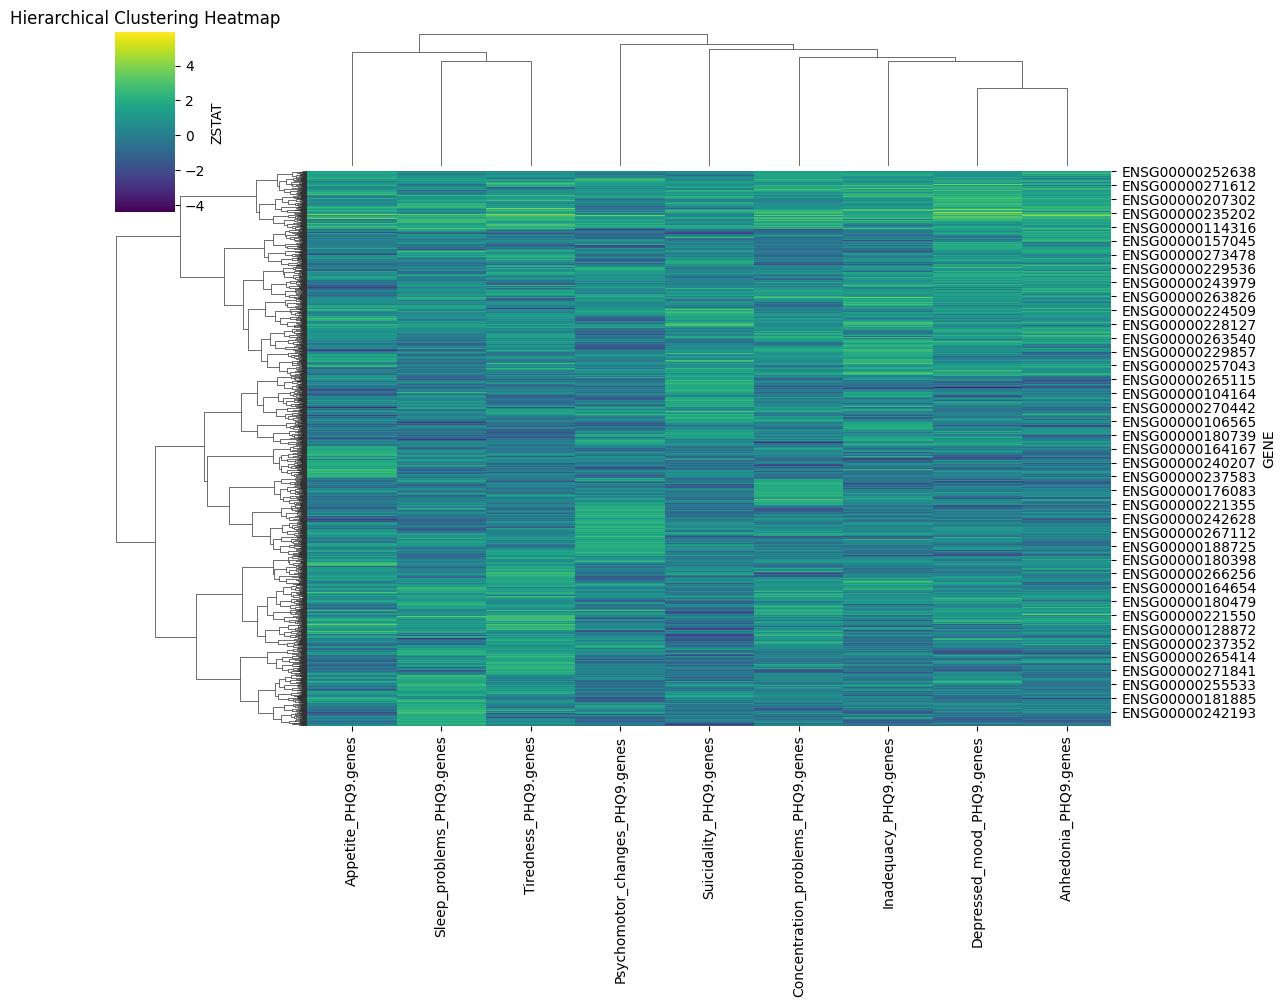

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

df_Hclust = merged_df.copy()

# Set the index to 'GENE'
df_Hclust.set_index('GENE', inplace=True)

# Create a clustered heatmap
plt.figure(figsize=(12, 10))
sns.clustermap(
    df_Hclust,
    cmap='viridis',
    cbar_kws={'label': 'ZSTAT'},
    method='ward',
    metric='euclidean',
    figsize=(12, 10)
)
plt.title('Hierarchical Clustering Heatmap')
plt.show()


Gaussian mixture models

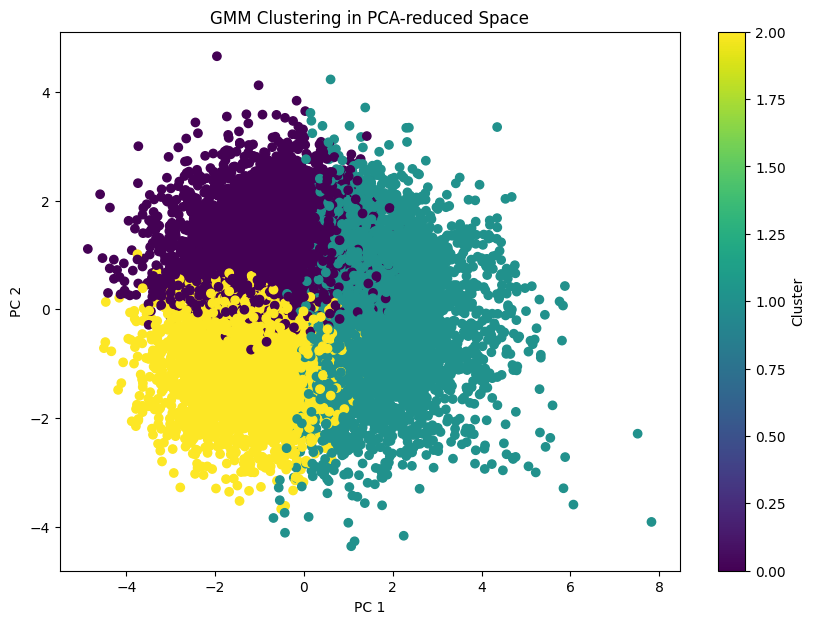

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

df_GMM = merged_df.copy()

# Set the index to 'GENE'
df_GMM.set_index('GENE', inplace=True)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_GMM)

# Fit GMM
n_components = 3
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm_labels = gmm.fit_predict(data_scaled)

# Add the GMM labels
df_GMM['Cluster'] = gmm_labels


# Plot custers in PC space
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
data_pca = pca.fit_transform(data_scaled)
plt.figure(figsize=(10, 7))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=gmm_labels, cmap='viridis', marker='o')
plt.title('GMM Clustering in PCA-reduced Space')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster')
plt.show()
